### Project Summary

This data science project involved employing the natural processing language technique ( text mining) to analyze almost 200,000 rows of Amazom reviews for a basket of beauty products and build a suite of competing machine-learning models to determine, based on the textual characteristics of the reviews, whether a review has a high or low rating.
In this predictive modeling exercise, we estimated 4 models, namely the naive bayes, xgboost, adaboost and random forest models. As is usually the case, the xgboost model proved superior in terms of performance,with an overall predictive accuracy of **72%** and precision and recall of **74%** and **66%** respectively. The adaboost and random forest models tied with an overall prediction accuracy of **68%** and the naive bayes model trailed with an overall prediction accuracy of **64%** performance.

In [262]:
import requests
from bs4 import BeautifulSoup
import sys
import json
import gzip
import unicodedata
import re
import operator
import parse
from pandas.io.json import json_normalize
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# to evaluate the models
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


#Classification Matrix
from sklearn.metrics import classification_report,confusion_matrix

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
# Cleaning the texts
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ChrisB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
comments_json='Beauty_5.json'
with open(comments_json) as cmnts:
     all_entries =cmnts.readlines()
parsable_data ="[" + ',' .join(all_entries).replace('\n','') + "]"


In [4]:
comments = pd.read_json(parsable_data, orient ='columns', typ = 'frame')

In [6]:
comments.tail()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
198497,B00LLPT4HI,"[0, 0]",5,Just a little dab of this shea butter should b...,"07 16, 2014",A2BLFCOPSMBOZ9,Dave Edmiston,A little dab...,1405468800
198498,B00LLPT4HI,"[0, 0]",5,This shea butter is completely raw and unrefin...,"07 14, 2014",A1UQBFCERIP7VJ,Margaret Picky,Pure organic raw shea butter,1405296000
198499,B00LLPT4HI,"[0, 0]",5,The skin is the body's largest organ and it ab...,"07 16, 2014",A35Q0RBM3YNQNF,M. Hill,One Pound Organic Grade A Unrefined Shea Butter,1405468800
198500,B00LLPT4HI,"[0, 0]",5,I have very dry elbows and knees. I have a to...,"07 15, 2014",A3LGT6UZL99IW1,"Richard C. Drew ""Anaal Nathra/Uthe vas Bethod...",This stuff is amazing!,1405382400
198501,B00LLPT4HI,"[0, 1]",5,This is 100% pure Shea Butter. Do not mistake ...,"07 22, 2014",A3UJRNI8UR4871,"Wulfstan ""wulfstan""","The ""Real Stuff""!",1405987200


In [46]:
comments.dtypes

asin              object
helpful           object
overall            int64
reviewText        object
reviewTime        object
reviewerID        object
reviewerName      object
summary           object
unixReviewTime     int64
ratings           object
dtype: object

In [7]:
comments.shape

(198502, 9)

In [8]:
comments.overall.unique()

array([1, 3, 4, 2, 5], dtype=int64)

In [9]:
comments.columns

Index(['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime'],
      dtype='object')

In [10]:
comments['overall'].value_counts()

5    114531
4     39741
3     22248
2     11456
1     10526
Name: overall, dtype: int64

In [11]:
print(comments['overall'].value_counts()/np.float(len(comments)))

5    0.576977
4    0.200205
3    0.112079
2    0.057712
1    0.053027
Name: overall, dtype: float64


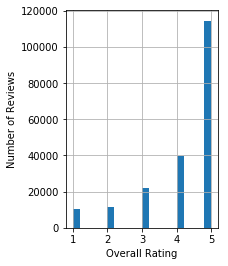

In [12]:
 plt.subplot(1, 2, 2)
fig = comments['overall'].hist(bins=20)
fig.set_ylabel('Number of Reviews')
fig.set_xlabel('Overall Rating')

plt.show()

In [42]:
# Recoding the ratings variable to create binary categories
comments['ratings'] = np.where(comments['overall'] <=2, 'low_ratings','high_ratings' ) 
    

In [43]:
# Checking the first five rows
comments.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,ratings
0,7806397051,"[3, 4]",1,Very oily and creamy. Not at all what I expect...,"01 30, 2014",A1YJEY40YUW4SE,Andrea,Don't waste your money,1391040000,low_ratings
1,7806397051,"[1, 1]",3,This palette was a decent price and I was look...,"04 18, 2014",A60XNB876KYML,Jessica H.,OK Palette!,1397779200,high_ratings
2,7806397051,"[0, 1]",4,The texture of this concealer pallet is fantas...,"09 6, 2013",A3G6XNM240RMWA,Karen,great quality,1378425600,high_ratings
3,7806397051,"[2, 2]",2,I really can't tell what exactly this thing is...,"12 8, 2013",A1PQFP6SAJ6D80,Norah,Do not work on my face,1386460800,low_ratings
4,7806397051,"[0, 0]",3,"It was a little smaller than I expected, but t...","10 19, 2013",A38FVHZTNQ271F,Nova Amor,It's okay.,1382140800,high_ratings


In [44]:
# Examining the distribution of the observations between the new ratings categories in terms of actual count/frequency
comments['ratings'].value_counts()

high_ratings    176520
low_ratings      21982
Name: ratings, dtype: int64

In [45]:
# Examining the distribution of the observations between the new ratings categories in terms of relative frequency
print(comments['ratings'].value_counts()/np.float(len(comments)))

high_ratings    0.889261
low_ratings     0.110739
Name: ratings, dtype: float64


In [47]:
# Recoding the ratings variable with numeric values
comments['ratings_n'] = np.where(comments['ratings'] == 'low_ratings', 0,1 ) 

In [49]:
# checking to see if the result is as intended
comments.head(3)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,ratings,ratings_n
0,7806397051,"[3, 4]",1,Very oily and creamy. Not at all what I expect...,"01 30, 2014",A1YJEY40YUW4SE,Andrea,Don't waste your money,1391040000,low_ratings,0
1,7806397051,"[1, 1]",3,This palette was a decent price and I was look...,"04 18, 2014",A60XNB876KYML,Jessica H.,OK Palette!,1397779200,high_ratings,1
2,7806397051,"[0, 1]",4,The texture of this concealer pallet is fantas...,"09 6, 2013",A3G6XNM240RMWA,Karen,great quality,1378425600,high_ratings,1


** the number of reviews with high ratings is disproportionally higher than  those with low ratings. Therefore, we will undersample the high rating category**

### Undersampling the majority class

In [50]:
# Subsetting all the events
events = comments[comments.ratings_n==1]

In [53]:
events.head(2)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,ratings,ratings_n
1,7806397051,"[1, 1]",3,This palette was a decent price and I was look...,"04 18, 2014",A60XNB876KYML,Jessica H.,OK Palette!,1397779200,high_ratings,1
2,7806397051,"[0, 1]",4,The texture of this concealer pallet is fantas...,"09 6, 2013",A3G6XNM240RMWA,Karen,great quality,1378425600,high_ratings,1


In [54]:
non_events.head(2)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,ratings,ratings_n
0,7806397051,"[3, 4]",1,Very oily and creamy. Not at all what I expect...,"01 30, 2014",A1YJEY40YUW4SE,Andrea,Don't waste your money,1391040000,low_ratings,0
3,7806397051,"[2, 2]",2,I really can't tell what exactly this thing is...,"12 8, 2013",A1PQFP6SAJ6D80,Norah,Do not work on my face,1386460800,low_ratings,0


In [51]:

# Subsetting all the non-events
non_events = comments[comments.ratings_n==0]

In [52]:
events.shape, non_events.shape

((176520, 11), (21982, 11))

In [61]:
# Taking a Random Sample of  21982 observations from the events dataset
# you can use random_state for reproducibility
events1 = events.sample(n=21982, random_state=2)


In [62]:
events1.shape

(21982, 11)

In [63]:
#Combining the events and non-events datasets
newdata = non_events.append(events1, ignore_index=True )

In [64]:
# Checking new data
newdata.shape


(43964, 11)

In [65]:
# Checking the new data
newdata.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,ratings,ratings_n
0,7806397051,"[3, 4]",1,Very oily and creamy. Not at all what I expect...,"01 30, 2014",A1YJEY40YUW4SE,Andrea,Don't waste your money,1391040000,low_ratings,0
1,7806397051,"[2, 2]",2,I really can't tell what exactly this thing is...,"12 8, 2013",A1PQFP6SAJ6D80,Norah,Do not work on my face,1386460800,low_ratings,0
2,7806397051,"[1, 3]",1,PLEASE DONT DO IT! this just rachett the palet...,"08 16, 2013",A1Z59RFKN0M5QL,"tasha ""luvely12b""",smh!!!,1376611200,low_ratings,0
3,7806397051,"[0, 1]",2,"Chalky,Not Pigmented,Wears off easily,Not a Co...","09 4, 2013",AWUO9P6PL1SY8,TreMagnifique,"Chalky, Not Pigmented, Wears off easily, Not a...",1378252800,low_ratings,0
4,9759091062,"[0, 0]",2,Did nothing for me. Stings when I put it on. I...,"07 13, 2014",A3LMILRM9OC3SA,NaN,"no Lightening, no Brightening,......NOTHING",1405209600,low_ratings,0


In [68]:
# Preparing data to create the sparse matrix
reviews = newdata[['reviewText', 'ratings_n']]

In [101]:
# Checking new dataset
reviews.head()

,reviewText,ratings_n
0,Very oily and creamy. Not at all what I expect...,0
1,I really can't tell what exactly this thing is...,0
2,PLEASE DONT DO IT! this just rachett the palet...,0
3,"Chalky,Not Pigmented,Wears off easily,Not a Co...",0
4,Did nothing for me. Stings when I put it on. I...,0


In [97]:
# Taking a Random Sample of  1000 observations from reviews the dataset to minimize the computation cost in the model building process
# you can use random_state for reproducibility
reviews_n = reviews.sample(n=1000, random_state=2)

In [104]:
# Checking the sample
reviews_n.head()

,reviewText,ratings_n
4226,Was not that happy with this product. The app...,0
28121,I will never go without this stuff. It makes a...,1
19950,I just couldn't like this razor. I travel a lo...,0
8085,This is the first self-tanner that I tried bef...,0
19649,Does nothing for my lashes. Barely gets any pr...,0


In [105]:
# Changing the row index
reviews_n.index = range(1000)

In [106]:
# Checking new indexes
reviews_n.head()

,reviewText,ratings_n
0,Was not that happy with this product. The app...,0
1,I will never go without this stuff. It makes a...,1
2,I just couldn't like this razor. I travel a lo...,0
3,This is the first self-tanner that I tried bef...,0
4,Does nothing for my lashes. Barely gets any pr...,0


In [253]:
# Checking the dimensions of the dataset
reviews_n.shape

(1000, 2)

In [107]:
# Cleaning the review data and removing meaningless words
corpus = []
for i in range(0, 1000):
    review = re.sub('[^a-zA-Z]', ' ', reviews_n['reviewText'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [108]:
# Checking the the fisrt row of the corpus
corpus[0]

'happi product applic hold onto serum use entir product see differ ever say work someon els work'

In [258]:
#Finding the length of the list
len(corpus)

1000

In [200]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 800)
X = cv.fit_transform(corpus).toarray()
y = reviews_n.iloc[:, 1].values

In [260]:
# Checking the shape of the feature space
X.shape

(1000, 800)

In [201]:
# Checking X
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [261]:
# Checking the shape of the dependent variable/label
y.shape

(1000,)

In [202]:
#Checking Y
y

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1,

In [245]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Naive Bayes Model

In [246]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

GaussianNB(priors=None)

In [247]:
# Predicting the Test set results
y_pred = NB_model.predict(X_test)

In [248]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
print('naive bayes test roc-auc: {}'.format(roc_auc_score(y_test, y_pred)))


naive bayes test roc-auc: 0.6431572629051621


In [250]:
# Making the Confusion Matrix  Naive Bayes

print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test,y_pred.round()))

[[75 27]
 [44 54]]
             precision    recall  f1-score   support

          0       0.63      0.74      0.68       102
          1       0.67      0.55      0.60        98

avg / total       0.65      0.65      0.64       200



In [249]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)


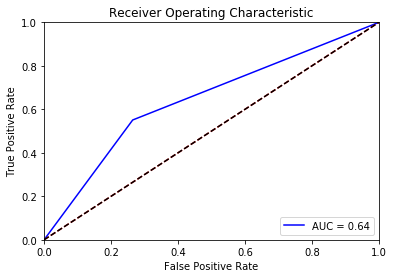

In [251]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### XGBoost Model

In [220]:
xgb_model = xgb.XGBClassifier()
eval_set = [(X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose=False)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [227]:
# Predicting the Test set results
y_pred = xgb_model.predict(X_test)

In [228]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
print('xgboost test roc-auc: {}'.format(roc_auc_score(y_test, y_pred)))

xgboost test roc-auc: 0.7188875550220089


In [229]:
# Making the Confusion Matrix - XGboost

print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test,y_pred.round()))

[[79 23]
 [33 65]]
             precision    recall  f1-score   support

          0       0.71      0.77      0.74       102
          1       0.74      0.66      0.70        98

avg / total       0.72      0.72      0.72       200



In [230]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

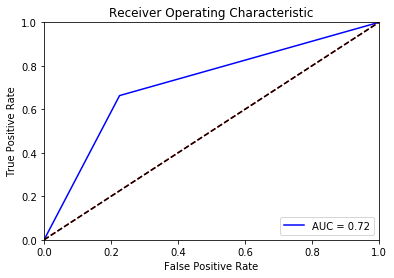

In [231]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Ada Boost Model

In [233]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [234]:
# Predicting the Test set results
y_pred = ada_model.predict(X_test)

In [235]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
print('adaboost test roc-auc: {}'.format(roc_auc_score(y_test, y_pred)))

adaboost test roc-auc: 0.6755702280912363


In [236]:
# Making the Confusion Matrix - Ada Boost

print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test,y_pred.round()))

[[66 36]
 [29 69]]
             precision    recall  f1-score   support

          0       0.69      0.65      0.67       102
          1       0.66      0.70      0.68        98

avg / total       0.68      0.68      0.67       200



In [237]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

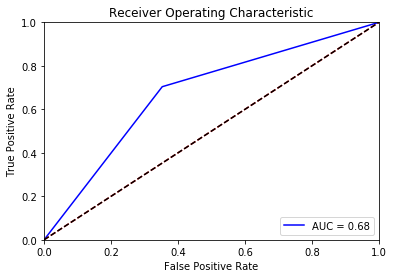

In [238]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random Forest Model

In [239]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [240]:
# Predicting the Test set results
y_pred = ada_model.predict(X_test)

In [241]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
print(' random forest test roc-auc: {}'.format(roc_auc_score(y_test, y_pred)))

 random forest test roc-auc: 0.6755702280912363


In [242]:
# Making the Confusion Matrix - Random Forest

print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test,y_pred.round()))

[[66 36]
 [29 69]]
             precision    recall  f1-score   support

          0       0.69      0.65      0.67       102
          1       0.66      0.70      0.68        98

avg / total       0.68      0.68      0.67       200



In [243]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

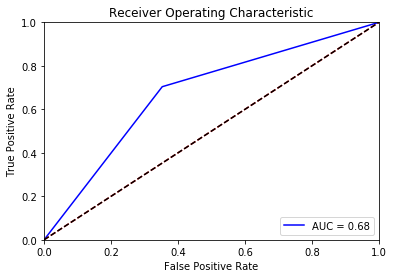

In [244]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Summary of Finding


In this predictive modeling exercise, we estimated 4 models, namely the naive bayes, xgboost, adaboost and random forest models. As is usually the case, the xgboost model proved superior in terms of performance,with an overall predictive accuracy of **72%** and precision and recall of **74%** and **66%** respectively. The adaboost and random forest models tied with an overall prediction accuracy of **68%** and the naive bayes model trailed with an overall prediction accuracy of **64%** performance.
